# pdf2md

In [34]:
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered

/home/zyx/anaconda3/envs/paperins/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
converter = PdfConverter(
    artifact_dict=create_model_dict(),
)

Loaded layout model s3://layout/2025_02_18 on device cuda with dtype torch.float16
Loaded texify model s3://texify/2025_02_18 on device cuda with dtype torch.float16
Loaded recognition model s3://text_recognition/2025_02_18 on device cuda with dtype torch.float16
Loaded table recognition model s3://table_recognition/2025_02_18 on device cuda with dtype torch.float16
Loaded detection model s3://text_detection/2025_02_28 on device cuda with dtype torch.float16
Loaded detection model s3://inline_math_detection/2025_02_24 on device cuda with dtype torch.float16


In [57]:
import os

directory = "./data/3"
pdf = [i for i in os.listdir(directory) if i.endswith(".pdf")]
pdf_path = os.path.join(directory, pdf[0])
rendered = converter(pdf_path)
text, _, images = text_from_rendered(rendered)

Running OCR Error Detection: 100%|██████████| 2/2 [00:00<00:00, 151.88it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


In [15]:
import re

def clean_markdown(text):
    # 保留换行符拆行
    lines = text.splitlines(keepends=True)

    # 删除 Markdown 和 HTML 图片
    image_pattern = re.compile(r"!\[[^\]]*\]\([^)]*\)|<img[^>]*>", re.IGNORECASE)
    lines = [image_pattern.sub('', line) for line in lines]

    # 找到第一个标题中包含 appendix/references 的行，截断其之前内容
    cutoff_index = len(lines)
    for i, line in enumerate(lines):
        if '#' in line and any(keyword in line.lower() for keyword in ['appendix', 'references']):
            cutoff_index = i
            break

    cleaned_lines = lines[:cutoff_index]

    return ''.join(cleaned_lines)  # 不做换行或压缩，保持原始结构

In [59]:
texts = text
text1 = clean_markdown(text)

In [60]:
with open(os.path.join(directory, "paper.txt"), "w", encoding="utf-8") as f:
    f.write(text1)

# 生成问题

In [ ]:
from openai import OpenAI

def gpt_chat(sys: str, user: str, provider: str) -> str:
    config = {
        "doubao": {
            "base_url": "https://ark.cn-beijing.volces.com/api/v3",
            "api_key": "",
            "model": "doubao-1-5-pro-32k-250115"
        },
        "kimi": {
            "base_url": "https://api.moonshot.cn/v1",
            "api_key": "",
            "model": "moonshot-v1-32k"
        },
        "qwen72": {
            "base_url": "https://dashscope.aliyuncs.com/compatible-mode/v1",
            "api_key": "",
            "model": "qwen2.5-72b-instruct"
        },
        "qwen32": {
            "base_url": "https://dashscope.aliyuncs.com/compatible-mode/v1",
            "api_key": "",
            "model": "qwen2.5-32b-instruct"
        },
        "deepseek": {
            "base_url": "https://api.deepseek.com/",
            "api_key": "",
            "model": "deepseek-chat"
        },
        "openai": {
            "base_url": "https://api.gptsapi.net/v1",
            "api_key": "",
            "model": "gpt-4o"
        }
    }

    if provider not in config:
        raise ValueError(f"Unknown provider: {provider}")

    cfg = config[provider]
    client = OpenAI(
        base_url=cfg["base_url"],
        api_key=cfg["api_key"]
    )

    completion = client.chat.completions.create(
        model=cfg["model"],
        messages=[
            {"role": "system", "content": sys},
            {"role": "user", "content": user}
        ]
    )
    return completion.choices[0].message.content


In [32]:
GET_QUESTIONS_TEMPLATE ="""
Hello, I need your expertise to generate a set of complex, thought-provoking questions based solely on the provided context.

<context>{context}</context>

Instructions:
* Generate a list of questions that are entirely derived from the information, data, and methods explicitly provided in the context.
* Ensure that each question requires no assumptions or information beyond what is stated in the context.
* Each question must be complex, requiring multiple steps of analysis, synthesis, or inference to answer, such as comparing data across tables, interpreting methodological implications, or deriving conclusions from results.
* Enclose each question within <question></question> tags.
* Do not number the questions.
* Generate up to {max_questions} questions.
"""

GET_QUESTIONS_SYSTEM_MESSAGE = """
You are a distinguished professor with expertise in analyzing academic papers and formulating rigorous, context-bound questions. 
Your role is to generate questions that are intellectually challenging, requiring deep analysis of the provided context alone. 
You must not rely on external knowledge or make assumptions beyond the explicit content of the context. 
Your primary objective is to create questions that demand multiple steps of reasoning, while ensuring all questions are fully grounded in the context.
"""

In [33]:
with open("./data/3/paper.txt", "r", encoding="utf-8") as f:
    text1 = f.read()

In [34]:
max_questions = 3
context = GET_QUESTIONS_TEMPLATE.format(
    context=text1,
    max_questions=max_questions
)
questions = gpt_chat(
    sys=GET_QUESTIONS_SYSTEM_MESSAGE,
    user=context,
    provider="deepseek"
)

In [103]:
import re
def extract_html_tags(text, keys):
    content_dict = {}
    keys = set(keys)
    for key in keys:
        pattern = f"<{key}>(.*?)</{key}>"
        matches = re.findall(pattern, text, re.DOTALL)
        # print(matches)
        if matches:
            content_dict[key] = [match.strip() for match in matches]
    return content_dict

def _validate_tasks(out):
    questions = extract_html_tags(out, ["question"])
    if "question" not in questions:
        return (
            out,
            False,
            f"Error: you did not generate questions within the <question></question> tags",
        )
    questions = questions["question"]
    # Check that there are at most max_questions questions
    if len(questions) > 3:
        return (
            out,
            False,
            f"Error: you can only ask at most {3} questions, but you asked {len(questions)}.",
        )

    return (questions, out), True, ""

In [35]:
a= _validate_tasks(questions)
a[0][0]

['How do the disparities in CO2 storage indicator (CSI) assessments and historical oil and gas production (HOGP) between high-income and lower-income countries reflect underlying inequalities in the global development of carbon dioxide geological storage (CGS), and what implications do these disparities have for climate justice and the design of international carbon market policies?',
 'Given that no countries plan to use subsurface carbon dioxide removal (CDR) alone without fossil CCS, and that high-income countries dominate commitments to both fossil CCS and subsurface CDR, what does this reveal about the perceived technological and economic barriers to standalone subsurface CDR deployment, and how might this imbalance affect the global ability to meet IPCC climate mitigation pathways?',
 'Why might countries with high historical oil and gas production (HOGP) be less likely to submit Long-Term Low-Emission Development Strategies (LT-LEDS) despite their higher likelihood of firm CGS c

In [36]:
with open("./data/3/question.txt", "w", encoding="utf-8") as f:
    for question in a[0][0]:
        f.write(question + "\n")

# 回答问题

In [ ]:
GET_ANSWER_TEMPLATE = """
Hello, I need your expertise to provide detailed, multi-step answers to the questions based solely on the provided context, showcasing a clear and logical reasoning process.

<questions>{questions}</questions>

<context>{context}</context>

Instructions:
- Provide a comprehensive answer to each question, addressing all aspects and subcomponents of the question.
- Ensure the answer is entirely derived from the information, data, and methods explicitly provided in the context, with no assumptions or information beyond the context.
- Answer in a logical, multi-step manner, explicitly labeling each step (e.g., "Step 1: Extract relevant data," "Step 2: Analyze relationships"). Each step should:
  - Clearly explain the reasoning process, including why specific data or methods are used.
  - Reference specific parts of the context (e.g., tables, figures, sections) to support the analysis.
  - Build toward the final conclusion through analysis, synthesis, or inference.
- Ensure the steps demonstrate complex reasoning, such as comparing multiple data points, interpreting methodological implications, or deriving conclusions from results.
- Do not include content unrelated to answering the question or unsupported by the context.
- Answer questions in the same order they were asked.
- Enclose each answer within <answer></answer> tags.
- Do not number the answers.
"""

GET_ANSWER_SYSTEM_MESSAGE = """
You are an expert in providing logical, multi-step reasoning and detailed answers to complex questions based solely on given contexts. 
Your role is to thoroughly analyze the questions and context, generating answers that are accurate, comprehensive, and strictly derived from the context without any external assumptions. 
Your answers must showcase a clear reasoning process, with each step explicitly labeled and explained, demonstrating complex analysis such as synthesizing data from tables or figures, evaluating methodological implications, or deriving insights from results. 
Your goal is to deliver answers that are logical, well-structured, transparent in their reasoning, and easy to follow, ensuring the inference process is fully visible and grounded in the context.
"""

In [38]:
qs=""
for idx in range(len(a[0][0])):
    qs += f"{idx+1}. {a[0][0][idx]}\n"

print(qs)

1. How do the disparities in CO2 storage indicator (CSI) assessments and historical oil and gas production (HOGP) between high-income and lower-income countries reflect underlying inequalities in the global development of carbon dioxide geological storage (CGS), and what implications do these disparities have for climate justice and the design of international carbon market policies?
2. Given that no countries plan to use subsurface carbon dioxide removal (CDR) alone without fossil CCS, and that high-income countries dominate commitments to both fossil CCS and subsurface CDR, what does this reveal about the perceived technological and economic barriers to standalone subsurface CDR deployment, and how might this imbalance affect the global ability to meet IPCC climate mitigation pathways?
3. Why might countries with high historical oil and gas production (HOGP) be less likely to submit Long-Term Low-Emission Development Strategies (LT-LEDS) despite their higher likelihood of firm CGS co

In [39]:
qs_context = GET_ANSWER_TEMPLATE.format(
    questions=qs,
    context=text1
)
answer = gpt_chat(sys=GET_ANSWER_SYSTEM_MESSAGE, user=qs_context, provider="deepseek")

In [40]:
final = extract_html_tags(answer, ["answer"])

In [43]:
import json
import os

qs_ans=[]

for idx in range(len(a[0][0])):
    tmp ={}
    tmp["question"] = a[0][0][idx]
    # tmp["answer"] = re.sub(r'\b\d+\.\s-', '',final["answer"][idx])
    tmp["answer"] = final["answer"][idx]
    qs_ans.append(tmp)
directory = "./data/3"
with open(os.path.join(directory,"data.json"), "w", encoding="utf-8") as f:
    
    json.dump(qs_ans, f, ensure_ascii=False, indent=4)

# 评估三元对

In [82]:
GET_EVALUATE_TEMPLATE = """
Hello, I need your help to evaluate the <question> and <answer> based on the provided <context>, focusing on scoring and analyzing errors in the answer's steps with actionable improvement suggestions.

<context>
{context}
</context>

<question>
{question}
</question>

<answer>
{answer}
</answer>

Instructions:
- Evaluate the question and answer against the following strict requirements:
    1. The question must be entirely derived from the context's explicit information, data, or methods, with no external assumptions or information.
    2. The question must be complex, requiring multi-step analysis, synthesis, or inference (e.g., comparing data across sections, interpreting methods, or deriving conclusions from multiple data points).
    3. The answer must fully and accurately address the question using only context-provided information, demonstrating rigorous, logical, multi-step reasoning that matches the question's complexity.
- Assign two scores from 1 to 10:
  - **Question Score**: Reflects how well the question meets requirements 1 and 2.
    - 1 = Relies heavily on external assumptions or is unrelated to the context.
    - 5 = Partially context-based or insufficiently complex (e.g., requires only simple recall or single-step analysis).
    - 8 = Mostly context-based and complex, with minor reliance on assumptions or slightly insufficient depth.
    - 10 = Fully context-based, highly complex, requiring rigorous multi-step analysis or synthesis.
  - **Answer Score**: Reflects how accurately, completely, and rigorously the answer addresses the question per requirement 3.
    - 1 = Completely incorrect, irrelevant, or unrelated to the context/question.
    - 5 = Partially correct, missing key steps, or lacking rigorous multi-step reasoning.
    - 8 = Mostly correct with minor omissions, inaccuracies, or insufficient reasoning depth.
    - 10 = Fully correct, complete, context-supported, with clear, logical, multi-step reasoning.
- Provide a concise analysis of errors in the answer's steps:
  - Identify each steps that are incorrect, incomplete, or insufficiently rigorous (e.g., introducing external assumptions, misinterpreting data, omitting key context, or weak reasoning).
  - For each questionable steps, provide a clear, actionable improvement suggestion, specifying how to correct the step using context-specific information (e.g., "Use data from Table X to support the conclusion").
  - Do not analyze the question or provide detailed context quotes unless necessary to explain the improvement.
  - If the answer lacks explicit steps, note this as an error and suggest how to structure the reasoning.
- Enclose evaluation within <evaluation></evaluation> tags.
- Output format:
  - Question Score: [1-10]
  - Answer Score: [1-10]
  - Answer Error Analysis: [Description of errors in specific steps, followed by actionable improvement suggestions]
- Example Output:
  - Question Score: 5
  - Answer Score: 6
  - Answer Error Analysis: Step 2 introduces external irrigation methods not in the context; revise to use irrigation data from paragraph 3. Step 3 misses biodiversity data; include metrics from Table 4 to strengthen the conclusion.
"""

GET_EVALUATE_SYSTEM_MESSAGE = """
You are an expert in evaluating questions and answers based on provided contexts, focusing on scoring and analyzing errors in the answer's steps with actionable improvement suggestions.
You should make your output satisfy the output format strictly.
"""

In [83]:
import json

file_index = 2
with open(f"./data/{file_index}/data.json","r",encoding="utf-8") as f:
    data=json.load(f)

with open(f"./data/{file_index}/paper.txt","r",encoding="utf-8") as f :
    context=f.read()

In [84]:
ques_index = 0

p = GET_EVALUATE_TEMPLATE.format(
    context=context,
    question=data[ques_index]["question"],
    answer=data[ques_index]["answer"]
)
print(p)


Hello, I need your help to evaluate the <question> and <answer> based on the provided <context>, focusing on scoring and analyzing errors in the answer's steps with actionable improvement suggestions.

<context>
# **nature food**

# **Vegans, vegetarians, fish-eaters and meat-eaters in the UK show discrepant environmental impacts**

Received: 15 June 2022

Accepted: 12 June 2023

Published online: 20 July 2023

 [C](http://crossmark.crossref.org/dialog/?doi=10.1038/s43016-023-00795-w&domain=pdf)heck for updates

**Peter Scarborough  1,2 , Michael Clark <sup>3</sup> , Linda Cobiac <sup>4</sup> , Keren Papier <sup>5</sup> , Anika Knuppel  <sup>7</sup> , John Lynch6 , Richard Harrington1,2, Tim Key <sup>5</sup> & Marco Springmann <sup>3</sup>**

Modelled dietary scenarios often fail to refect true dietary practice and do not account for variation in the environmental burden of food due to sourcing and production methods. Here we link dietary data from a sample of 55,504 vegans, vegetaria

In [85]:
eval = gpt_chat(
    sys=GET_EVALUATE_SYSTEM_MESSAGE,
    user=p,
    provider="openai"
)

In [93]:
eval

"<evaluation>\n- Question Score: 10  \n- Answer Score: 9  \n- Answer Error Analysis:  \n\nThe answer is highly detailed and provides logical multi-step reasoning to fully address the question. However, there are minor areas where the explanation could have been improved for greater precision:  \n\n1. **Step 1 (Data Extraction)**: The overview of relevant metrics and relative differences is well-presented by deriving appropriate comparisons from Table 3. However, it does not explicitly address the differences in absolute vs. relative impacts across metrics for vegan diets—this would strengthen the analysis.  \n   - **Improvement Suggestion**: Include specific values for vegan diets under each metric to illustrate how their impact changes in absolute terms across GWP100, GTP100, and GWP20.  \n\n2. **Step 2 (Impact Analysis of Metrics)**: The step provides a concise analysis of the effects of metric choice on relative differences, particularly emphasizing CH4. However, it assumes that abs

In [104]:

c = extract_html_tags(eval,["evaluation"])
c

{'evaluation': ["- Question Score: 10  \n- Answer Score: 9  \n- Answer Error Analysis:  \n\nThe answer is highly detailed and provides logical multi-step reasoning to fully address the question. However, there are minor areas where the explanation could have been improved for greater precision:  \n\n1. **Step 1 (Data Extraction)**: The overview of relevant metrics and relative differences is well-presented by deriving appropriate comparisons from Table 3. However, it does not explicitly address the differences in absolute vs. relative impacts across metrics for vegan diets—this would strengthen the analysis.  \n   - **Improvement Suggestion**: Include specific values for vegan diets under each metric to illustrate how their impact changes in absolute terms across GWP100, GTP100, and GWP20.  \n\n2. **Step 2 (Impact Analysis of Metrics)**: The step provides a concise analysis of the effects of metric choice on relative differences, particularly emphasizing CH4. However, it assumes that a

# Improve

In [4]:
import json
file_index =7
with open(f"./data/{file_index}/data.json","r",encoding="utf-8") as f:
    data=json.load(f)
with open(f"./data/{file_index}/paper.txt","r",encoding="utf-8") as f:
    content = f.read()

In [5]:
data[2]["evaluation"]

'- Question Score: 9  \n- Answer Score: 7  \n- Answer Error Analysis:  \n  1. **Step 1 (Define exclusion criteria impact)**: The delineation of the exclusion criteria is correct but overly general. While the exclusions of multi-water-type studies and grey literature were mentioned, the step does not utilize sufficient detail directly from the context, such as explicit examples or the rationale behind these exclusions. Suggestion: Incorporate examples from the context (e.g., Vermaire et al., 2017) to provide a sharper explanation of why these exclusions are important and how they might affect the AI’s performance.  \n\n  2. **Step 2 (Analyze representativeness limitations)**:  \n      - The reasoning about the "narrowed scope" and "publication bias" is generally valid but misses contextual specifics related to QA/QC scoring. For example, the context discusses how multi-water-type studies could introduce methodological variability pertinent to QA/QC scoring criteria. Suggestion: Explicit

In [6]:
data[2]["evaluation_1"]

"- Question Score: 10  \n- Answer Score: 8  \n- Answer Error Analysis:  \n\n1. **Step 1 (Define exclusion criteria impact using contextual specifics)**:  \n   - While this step identifies the exclusions of multi-water-type studies and grey literature, it does not sufficiently emphasize how these exclusions interact directly with the defined goal of the QA/QC framework (i.e., creating a more consistent scoring methodology). The analysis could be strengthened by explicitly linking these exclusions to the challenges of semantic ambiguity or evaluator bias in QA/QC scoring as mentioned in the introduction.  \n   - **Improvement Suggestion**: Include an explicit reference to how the exclusions reduce the potential for evaluator bias or inconsistencies, a key argument in the context. For instance, argue that homogeneous datasets simplify the application of QA/QC scoring criteria, reducing misinterpretation.\n\n2. **Step 2 (Analyze representativeness limitations tied to QA/QC criteria)**:  \n

In [3]:
import re

def extract_scores(text):
    patterns = {
        "Question Score": r"(?:Question Score|问题分数)[:\-*\s]+(\d+)",
        "Answer Score": r"(?:Answer Score|答案分数)[:\-*\s]+(\d+)"
    }
    scores = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            scores[key] = int(match.group(1))
        else:
            scores[key] = None
    return scores

In [141]:
score = extract_scores(data[ques_index]["evaluation"])
score["Answer Score"]

8

In [127]:
IMPROVE_ANSWER_TEMPLATE = """
hi, I need your help to improve my detailed, multi-step answer based on the provided context and professor's comments.

<questions>{question}</questions>

<context>{context}</context>

<answer>{answer}</answer>

<comments>{comment}</comments>

Instructions:
- You should completely utilize the context and comments to improve the answer, espically the professor's comments.
- Improve the answer based on the comments and context, under these requirements or constraints:
  - Provide a comprehensive answer to each question, addressing all aspects and subcomponents of the question.
  - Ensure the answer is entirely derived from the information, data, and methods explicitly provided in the context, with no assumptions or information beyond the context.
  - Answer in a logical, multi-step manner, explicitly labeling each step (e.g., "Step 1: Extract relevant data," "Step 2: Analyze relationships"). Each step should:
    - Clearly explain the reasoning process, including why specific data or methods are used.
    - Reference specific parts of the context (e.g., tables, figures, sections) to support the analysis.
    - Build toward the final conclusion through analysis, synthesis, or inference.
  - Ensure the steps demonstrate complex reasoning, such as comparing multiple data points, interpreting methodological implications, or deriving conclusions from results.
  - Do not include content unrelated to answering the question or unsupported by the context.
- No other explanations for the improvement are needed.
- Enclose each answer within <answer></answer> tags.
"""

IMPROVE_ANSWER_SYSTEM_MESSAGE = """
You are an expert at improving  logical, multi-step reasoning and comprehensive answers to complex questions based on the given context and comments. 
Your task is to improve the given answer based on the professor's comment and keep the same format.
"""

In [128]:
prompt = IMPROVE_ANSWER_TEMPLATE.format(
    question=data[ques_index]["question"],
    context=content,
    answer=data[ques_index]["answer"],
    comment=data[ques_index]["evaluation"]
)

In [129]:
new_answer = gpt_chat(
    sys=IMPROVE_ANSWER_SYSTEM_MESSAGE,
    user=prompt,
    provider="deepseek"
)

In [130]:
p = GET_EVALUATE_TEMPLATE.format(
    context=content,
    question=data[ques_index]["question"],
    answer=new_answer
)

In [131]:
eval1 = gpt_chat(
    sys=GET_EVALUATE_SYSTEM_MESSAGE,
    user=p,
    provider="openai"
)

In [132]:
print(eval1)

<evaluation>
- Question Score: 10  
- Answer Score: 8  
- Answer Error Analysis:  
  1. **Step 1** is primarily focused on highlighting the performance benefits of assimilation, which aligns well with the context. However, while it correctly mentions PM2.5 improvements (~67% correlation enhancement, ~38% bias reduction), the analysis could be clearer by directly linking these statistics to regional variability in EPA regions. Improvement Suggestion: Explicitly mention that the statistical performance metrics validate the model's assimilation benefits for individual EPA regions, referencing the variability within correlation coefficients and biases as shown in Figs. 7–8.  
  2. **Step 2** incorrectly treats emission variability factors (1.16–2.94 for anthropogenic sources, 3.13–8.0 for fires) as comprehensive when these are representative but not exhaustive. Moreover, meteorological errors like overestimated wind speeds are outlined without articulating their localized effects on correl

In [134]:
print(data[ques_index]["evaluation"])

- Question Score: 10  
- Answer Score: 8  
- Answer Error Analysis:  

1. **Step 1: Extract performance metrics from the context**  
   - This step is mostly correct as it accurately extracts the performance metrics for surface ozone and PM2.5 (correlation coefficients, MB, and RMSE) from the context. However, it misses the additional details about the specific improvements introduced by assimilation, such as the ~67% improvement in PM2.5 correlations and 38% reduction in biases, which are explicitly mentioned in Section 2.3.  
   - **Improvement Suggestion**: Explicitly include the quantified benefits of assimilation highlighted in Section 2.3 to fully capture its impact on model performance.

2. **Step 2: Analyze regional variations**  
   - While the analysis correctly identifies over- and underestimation trends (e.g., ozone overestimation in Regions 8 and 9, PM2.5 underestimation in Region 8 and overestimation in Region 2), it introduces a minor interpretive gap. The discussion wou

# Display

In [23]:
ori_ques_score=[]
ori_ans_score=[]
new_ques_score=[]
new_ans_score=[]
for i in range(1,11):
    with open(f"./data/{i}/data.json","r",encoding="utf-8") as f:
        data=json.load(f)
    for j in range(3):
        score = extract_scores(data[j]["evaluation"])
        ori_ques_score.append(score["Question Score"])
        ori_ans_score.append(score["Answer Score"])
        if "evaluation_1" in data[j]:
            score1 = extract_scores(data[j]["evaluation_1"])
            new_ans_score.append(score1["Answer Score"])
        else:
            new_ans_score.append(score["Answer Score"])

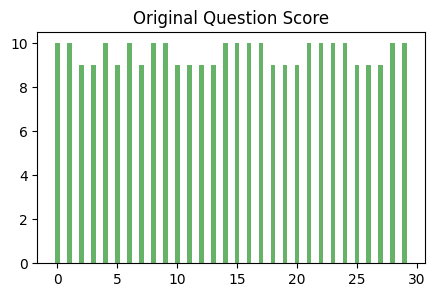

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 3))
plt.bar(np.arange(len(ori_ques_score)), ori_ques_score, width=0.4,label='Original Question Score', color='green', alpha=0.6)
plt.title('Original Question Score')
plt.show()

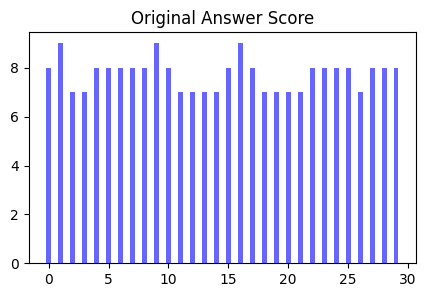

In [16]:
plt.figure(figsize=(5, 3))
plt.bar(np.arange(len(ori_ans_score)), ori_ans_score, width=0.4,label='Original Answer Score', color='blue', alpha=0.6)
plt.title('Original Answer Score')
plt.show()

In [24]:
len(ori_ans_score)


30

In [25]:
len(new_ans_score)

30

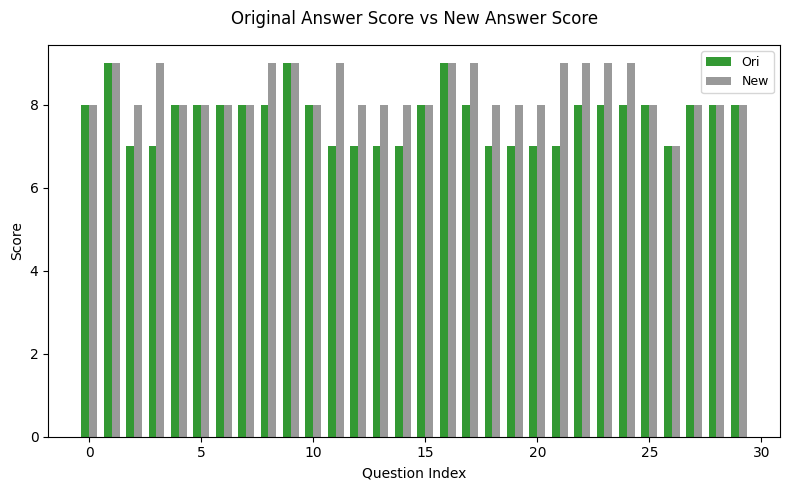

In [32]:
x = np.arange(len(ori_ans_score))  # x 轴坐标
width = 0.35  # 柱状图宽度

plt.figure(figsize=(8, 5))  # 调整画布大小

# 绘制 Original Answer Score（左侧）
plt.bar(x - width/2, ori_ans_score, width=width, label='Ori', color='green', alpha=0.8)

# 绘制 New Answer Score（右侧）
plt.bar(x + width/2, new_ans_score, width=width, label='New', color="grey", alpha=0.8)

# 添加标题、标签和图例
plt.title('Original Answer Score vs New Answer Score', fontsize=12, pad=15)
plt.xlabel('Question Index', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.legend(loc='upper right', fontsize=9)

# 调整布局，避免标签重叠
plt.tight_layout()
plt.show()

In [4]:
import json
ori_ans_score=[]
new_ans_score=[]
for i in range(1,7):
    with open(f"./data/{i}/data.json","r",encoding="utf-8") as f:
        data=json.load(f)
    for j in range(3):
        if "evaluation_2" in data[j]:
            score = extract_scores(data[j]["evaluation"])
            ori_ans_score.append(score["Answer Score"])
            score1 = extract_scores(data[j]["evaluation_1"])
            new_ans_score.append(score1["Answer Score"])

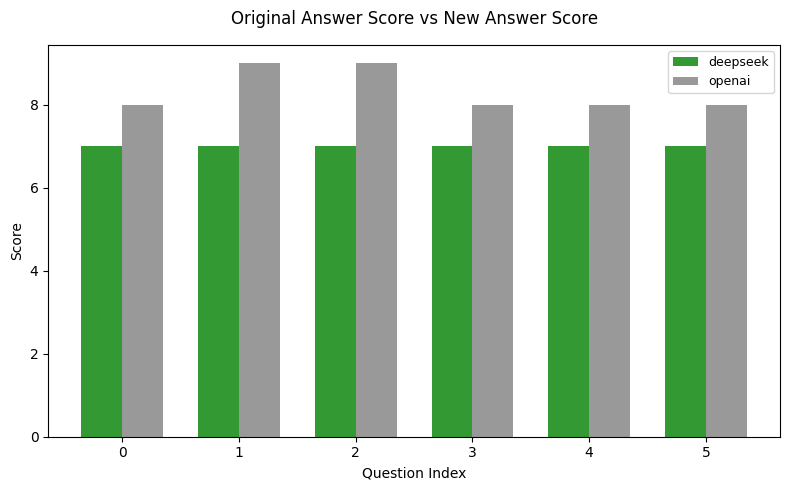

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(ori_ans_score))  # x 轴坐标
width = 0.35  # 柱状图宽度

plt.figure(figsize=(8, 5))  # 调整画布大小

# 绘制 Original Answer Score（左侧）
plt.bar(x - width/2, ori_ans_score, width=width, label='deepseek', color='green', alpha=0.8)

# 绘制 New Answer Score（右侧）
plt.bar(x + width/2, new_ans_score, width=width, label='openai', color="grey", alpha=0.8)

# 添加标题、标签和图例
plt.title('Original Answer Score vs New Answer Score', fontsize=12, pad=15)
plt.xlabel('Question Index', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.legend(loc='upper right', fontsize=9)

# 调整布局，避免标签重叠
plt.tight_layout()
plt.show()

In [9]:
import json
ori_ans_score=[]
new_ans_score=[]
for i in range(1,7):
    with open(f"./data/{i}/data.json","r",encoding="utf-8") as f:
        data=json.load(f)
    for j in range(3):
        if "evaluation_3" in data[j]:
            score = extract_scores(data[j]["evaluation_3"])
            ori_ans_score.append(score["Answer Score"])
            score1 = extract_scores(data[j]["evaluation_4"])
            new_ans_score.append(score1["Answer Score"])

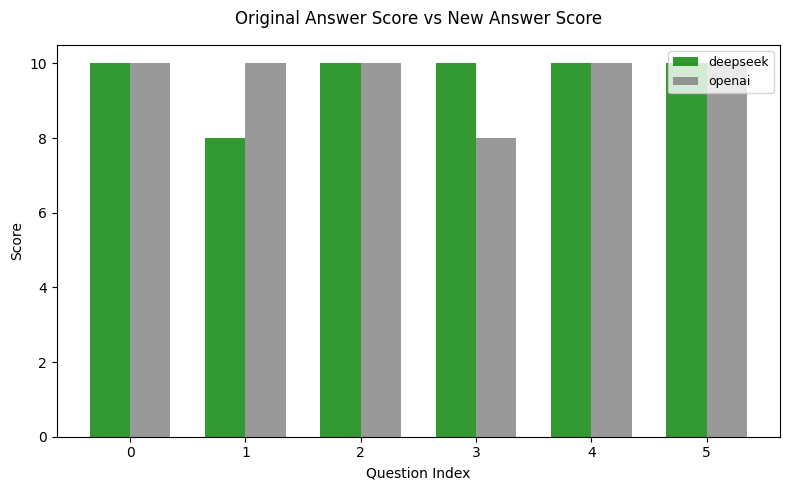

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(ori_ans_score))  # x 轴坐标
width = 0.35  # 柱状图宽度

plt.figure(figsize=(8, 5))  # 调整画布大小

# 绘制 Original Answer Score（左侧）
plt.bar(x - width/2, ori_ans_score, width=width, label='deepseek', color='green', alpha=0.8)

# 绘制 New Answer Score（右侧）
plt.bar(x + width/2, new_ans_score, width=width, label='openai', color="grey", alpha=0.8)

# 添加标题、标签和图例
plt.title('Original Answer Score vs New Answer Score', fontsize=12, pad=15)
plt.xlabel('Question Index', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.legend(loc='upper right', fontsize=9)

# 调整布局，避免标签重叠
plt.tight_layout()
plt.show()